In [1]:
from PIL import Image
import matplotlib.pyplot as plt

# 集成学习
aggregation type | blending |  learning
---|---|---
uniform | voting/averaging | Bagging
non-uniform |linear | AdaBoost
conditional|  stacking|  Decision Tree

## selecting ?
选择模型最好的
## voting（投票法）
模型融合其实也没有想象的那么高大上，从最简单的Voting说起，这也可以说是一种模型融合。假设对于一个二分类问题，有3个基础模型，那么就采取投票制的方法，投票多者确定为最终的分类。
## averaging（平均/加权平均法）
对数值型输出，平均法是最常用的策略，解决回归问题。

对于回归问题，一个简单直接的思路是取平均。稍稍改进的方法是进行加权平均。权值可以用排序的方法确定，举个例子，比如A、B、C三种基本模型，模型效果进行排名，假设排名分别是1，2，3，那么给这三个模型赋予的权值分别是3/6、2/6、1/6
**这两种方法看似简单，其实后面的高级算法也可以说是基于此而产生的** ，Bagging或者Boosting都是一种把许多弱分类器这样融合成强分类器的思想。

## bagging（代表算法：随机森林）
Bagging就是采用有放回的方式进行抽样，用抽样的样本建立子模型,对子模型进行训练，这个过程重复多次，最后进行融合。
大概分为这样两步：
1. 重复K次
  - 有放回地重复抽样建模
  - 训练子模型

2. 模型融合
  - 分类问题：voting
  - 回归问题：average

Bagging算法不用我们自己实现，随机森林就是基于Bagging算法的一个典型例子，采用的基分类器是决策树。


### BaggingClassifier or RandomForestClassifier
oob_score_属性：约有37%（【(1-1/n)^n】=1/e）的样本没有用来训练,这一部分称为out-of-bag(oob),因为模型没有见过这部分样本，所以可以拿来当验证集合，而不需要再划分验证集或者交叉验证了。
比如我们计算accuracy_score时，也可以看下oob_score_的情况

## boosting（代表算法：xgboost, lightgbm）
Bagging算法可以并行处理，而Boosting的思想是一种迭代的方法(串行)，每一次训练的时候都更加关心分类错误的样例，给这些分类错误的样例增加更大的权重，下一次迭代的目标就是能够更容易辨别出上一轮分类错误的样例。最终将这些弱分类器进行加权相加。
![](img/boosting_01.jpg)
![](img/boosting_02.jpg)

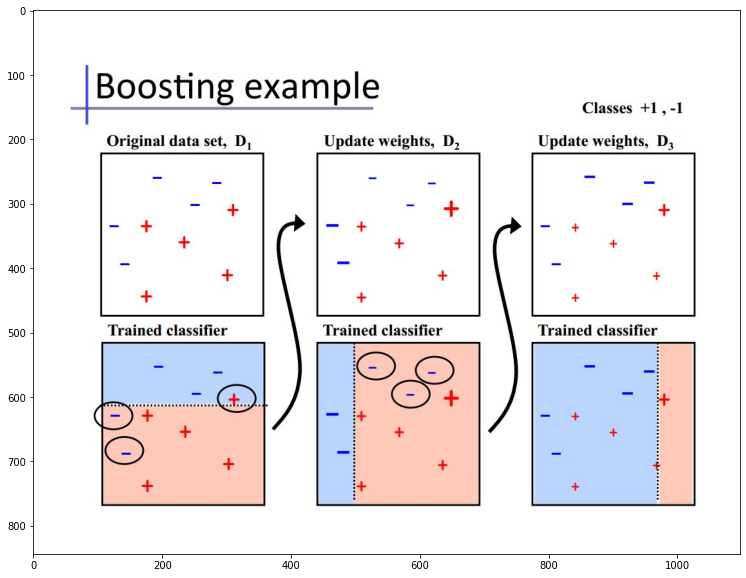

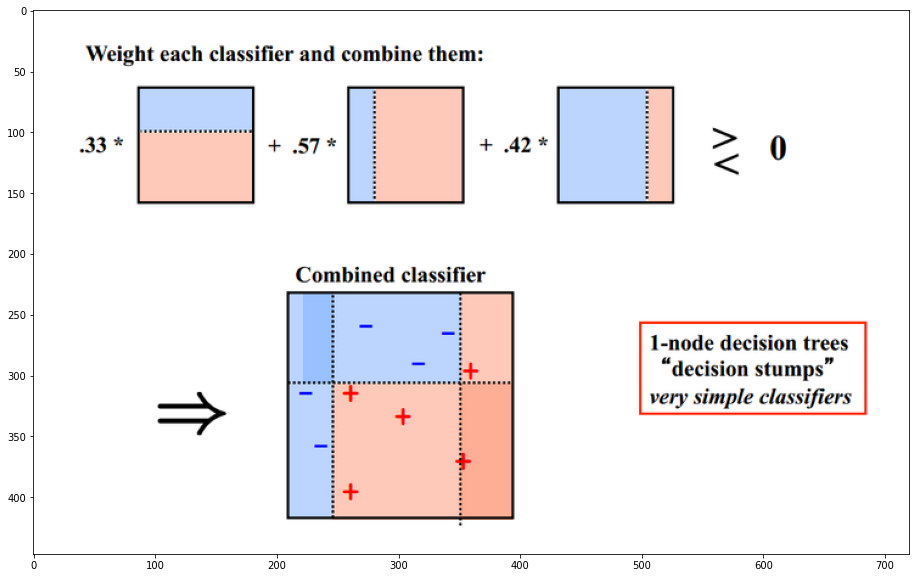

In [2]:
img = Image.open("./img/boosting_01.jpg")
plt.figure(figsize=(20,10)) #设置窗口大小
plt.imshow(img)
img = Image.open("./img/boosting_02.jpg")
plt.figure(figsize=(20,10)) #设置窗口大小
plt.imshow(img)

## Stacking（学习法）
Stacking流程比较复杂因为涉及到交叉验证的过程，其流程与Blending类似，具体如下：

1. 将数据划分为训练集和测试集(test_set)，对训练集进行划分为K个大小相似的集合，取其中一份作为验证集val_set,其余的为训练集train_set；
2. 创建第一层的多个模型，这些模型可以使同质的也可以是异质的；
3. 对于每一个模型来说，train_set和val_set是不一样的，如图所示；然后利用各自的train_set训练各自的模型，训练好的模型对各自的val_set和test_set进行预测，得到val_predict和test_predict；
4. 创建第二层的模型，将每个模型对应的val_predict拼接起来作为第二层的训练集，将所有模型的test_predict取平均值作为第二层的测试集；用训练好的第二层模型对第二层的测试集进行预测，得到的结果即为整个测试集的结果
![](img/stacking_01.png)

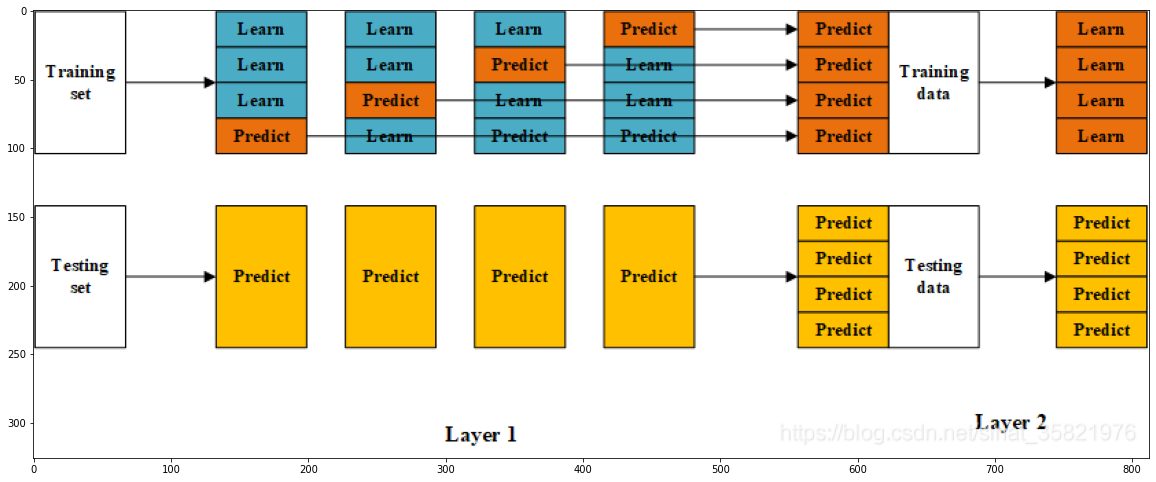

In [3]:
img = Image.open("./img/stacking_01.png")
plt.figure(figsize=(20,10)) #设置窗口大小
plt.imshow(img)

## Blending
[Blending and Bagging](https://www.bilibili.com/video/BV1ix411i7yp?p=26)
Blending相较于Stacking来说要简单一些，其流程大致分为以下几步：

1. 将数据划分为训练集和测试集(test_set)，其中训练集需要再次划分为训练集(train_set)和验证集(val_set)；
2. 创建第一层的多个模型，这些模型可以使同质的也可以是异质的；
3. 使用train_set训练步骤2中的多个模型，然后用训练好的模型预测val_set和test_set得到val_predict, test_predict1；
4. 创建第二层的模型,使用val_predict作为训练集训练第二层的模型；
5. 使用第二层训练好的模型对第二层测试集test_predict1进行预测，该结果为整个测试集的结果
![](img/blending_01.png)

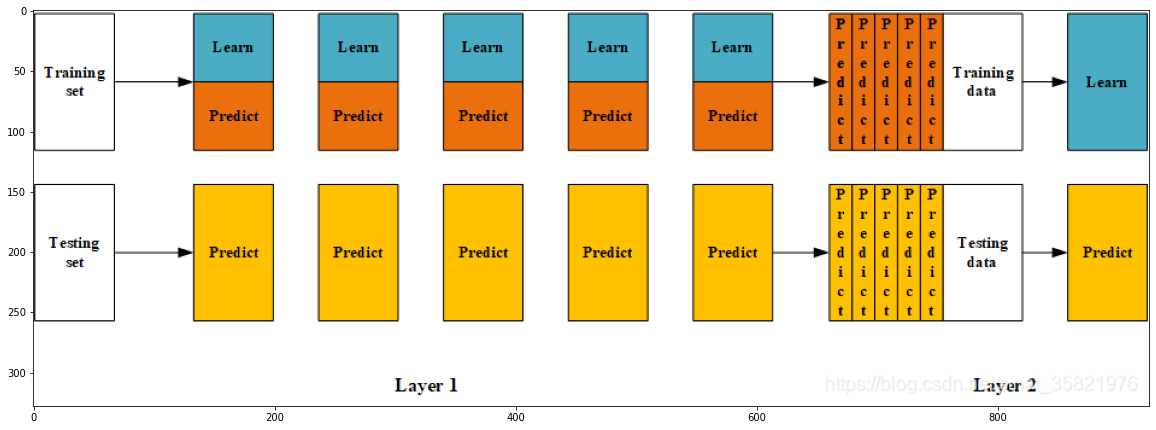

In [4]:
img = Image.open("./img/blending_01.png")
plt.figure(figsize=(20,10)) #设置窗口大小
plt.imshow(img)

## 参考
[集成学习-组合策略与Stacking](https://www.cnblogs.com/yanshw/p/11112712.html)

In [5]:
# Stacking：

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# 创建训练的数据集
data, target = make_blobs(n_samples=50000, centers=2, random_state=0, cluster_std=0.60)

# 模型融合中使用到的各个单模型
clfs = [RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]

# 切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.3, random_state=2020)

# 最后 训练data_blend_train, 来预测 dataset_blend_test
dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_predict.shape[0], len(clfs)))

# 5折stacking, 分层采样、StratifiedKFold保证每次采样数据集中各个类别比例相同
skf = StratifiedKFold(n_splits=5)

for j, clf in enumerate(clfs):
    '''依次训练各个单模型'''
    dataset_blend_test_j = np.zeros((X_predict.shape[0], 5))
    for i, (train, test) in enumerate(skf.split(X, y)):
        # 使用第i个部分作为预测，剩余的部分来训练模型，获得其预测的输出作为第i部分的新特征。
        X_train, y_train, X_test, y_test = X[train], y[train], X[test], y[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_predict)[:, 1]  # X_predict 是第一次train_test_split切分输出的测试X
    # 对于测试集，直接用这k个模型的预测值均值作为新的特征。
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_blend_test[:, j]))


clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(dataset_blend_train, y)
y_submission = clf.predict_proba(dataset_blend_test)[:, 1]

print("Linear stretch of predictions to [0,1]")
y_submission = (y_submission - y_submission.min()) / (y_submission.max() - y_submission.min())
print("blend result")
print("val auc Score: %f" % (roc_auc_score(y_predict, y_submission)))


val auc Score: 0.999927
val auc Score: 0.999862
val auc Score: 0.999859
val auc Score: 0.999925
val auc Score: 0.999731
Linear stretch of predictions to [0,1]
blend result
val auc Score: 0.999926


In [6]:
# Blending：

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# 创建训练的数据集
data, target = make_blobs(n_samples=50000, centers=2, random_state=0, cluster_std=0.60)

# 模型融合中使用到的各个单模型
clfs = [RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        RandomForestClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='gini'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=5)]

# 切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(data, target, test_size=0.33, random_state=666)

# 切分训练数据集为d1,d2两部分
X_d1, X_d2, y_d1, y_d2 = train_test_split(X, y, test_size=0.5, random_state=666)
dataset_d1 = np.zeros((X_d2.shape[0], len(clfs)))
dataset_d2 = np.zeros((X_predict.shape[0], len(clfs)))

for j, clf in enumerate(clfs):
    # 依次训练各个单模型
    # 使用第1个部分作为预测，第2部分来训练模型，获得其预测的输出作为第2部分的新特征。
    clf.fit(X_d1, y_d1)
    y_submission = clf.predict_proba(X_d2)[:, 1]
    dataset_d1[:, j] = y_submission
    # 对于测试集，直接用这k个模型的预测值作为新的特征。
    dataset_d2[:, j] = clf.predict_proba(X_predict)[:, 1]
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_d2[:, j]))

# 融合使用的模型
clf = GradientBoostingClassifier(learning_rate=0.02, subsample=0.5, max_depth=6, n_estimators=30)
clf.fit(dataset_d1, y_d2)
y_submission = clf.predict_proba(dataset_d2)[:, 1]

print("Linear stretch of predictions to [0,1]")
y_submission = (y_submission - y_submission.min()) / (y_submission.max() - y_submission.min())
print("blend result")
print("val auc Score: %f" % (roc_auc_score(y_predict, y_submission)))

val auc Score: 0.999444
val auc Score: 0.999510
val auc Score: 0.999744
val auc Score: 0.999742
val auc Score: 0.999199
Linear stretch of predictions to [0,1]
blend result
val auc Score: 0.999021
